In [90]:
import random
import numpy
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima
from pmdarima.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error


plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = (10, 6)



def generate_time_series_data(start_date, end_date):
    """Generates time series data using specified start_date and end_date.

    Args:
        start_date (_type_): _description_
        end_date (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = []
    current_date = start_date

    while current_date <= end_date:
        revenue = random.randint(1000, 10000)
        data.append((current_date, revenue))
        current_date += timedelta(days=1)

    return data


data = generate_time_series_data(datetime(2024, 1, 1), datetime(2024, 3, 31))
dates = [d[0] for d in data]
revenues = [d[1] for d in data]

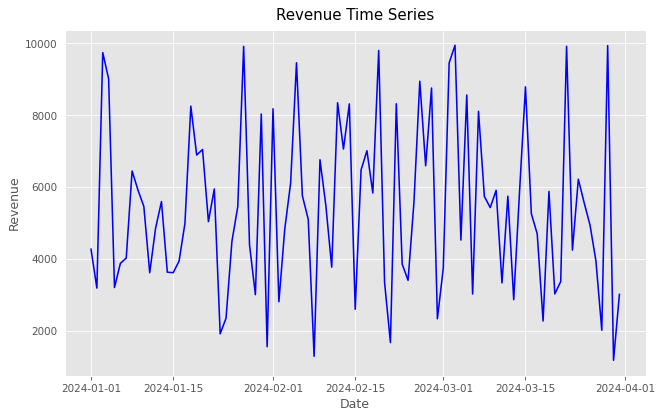

In [84]:
def plot_time_series(dates, revenues, title='Revenue Time Series', xlabel='Date', ylabel='Revenue'):
    plt.plot(dates, revenues, color='blue', linestyle='solid')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


plot_time_series(dates, revenues)

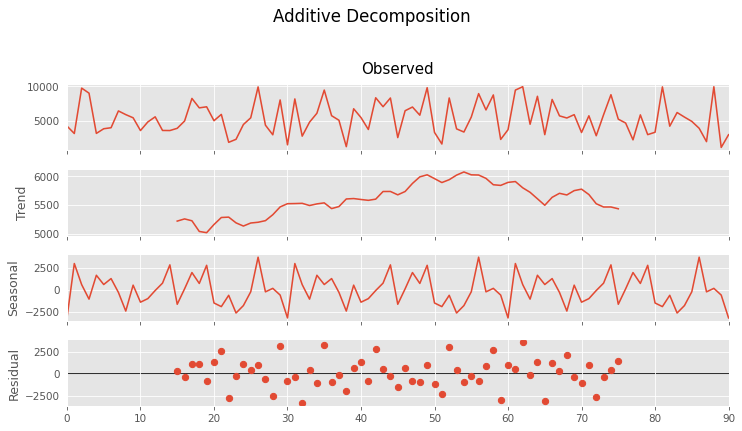

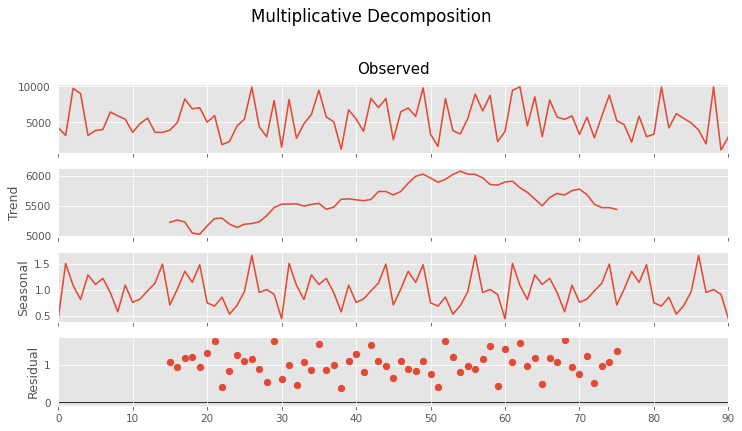

In [85]:
def seasonal_decompose(dates, revenues):
    
    multiplicative_decomposition = sm.tsa.seasonal_decompose(revenues, model='multiplicative', period=30)
    additive_decomposition = sm.tsa.seasonal_decompose(revenues, model='additive', period=30) 
    
    additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()

seasonal_decompose(dates, revenues)

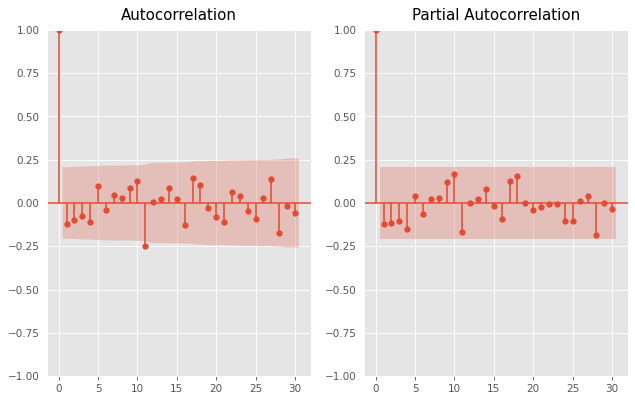

In [86]:
def acf_pacf(dates, revenues):
    fig, ax = plt.subplots(1, 2)
    sm.graphics.tsa.plot_acf(revenues, lags=30, ax=ax[0])
    sm.graphics.tsa.plot_pacf(revenues, lags=30, ax=ax[1])
    plt.show()
    
acf_pacf(dates, revenues)

In [87]:
def stationarity_test(dates, revenues):
    adf, pval, usedlag, nobs, crit_vals, icbest = sm.tsa.stattools.adfuller(revenues)
    print('ADF test statistic:', adf)
    print('ADF p-values:', pval)
    
    if pval < 0.05:
        print('-----Reject null hypothesis (non-stationarity), accept alternative hypothesis (data is stationary)-----')
    else:
        # Difference the data
        diff_revenues = numpy.diff(revenues)
        adf_diff, pval_diff, usedlag_diff, nobs_diff, crit_vals_diff, icbest_diff = sm.tsa.stattools.adfuller(diff_revenues)
        print('ADF test statistic after differencing:', adf_diff)
        print('ADF p-values after differencing:', pval_diff)
        
        if pval_diff < 0.05:
            print('-----Reject null hypothesis after differencing (non-stationarity), accept alternative hypothesis (data is stationary)-----')
        else:
            # Detrend the data
            detrend_revenues = sm.tsa.detrend(revenues)
            adf_detrend, pval_detrend, usedlag_detrend, nobs_detrend, crit_vals_detrend, icbest_detrend = sm.tsa.stattools.adfuller(detrend_revenues)
            print('ADF test statistic after detrending:', adf_detrend)
            print('ADF p-values after detrending:', pval_detrend)
            
            if pval_detrend < 0.05:
                print('-----Reject null hypothesis after detrending (non-stationarity), accept alternative hypothesis (data is stationary)-----')
            else:
                # Deseasonalize the data
                seasonal_decompose = sm.tsa.seasonal_decompose(revenues, model='multiplicative', period=30)
                deseasonal_revenues = revenues / seasonal_decompose.seasonal
                adf_deseasonal, pval_deseasonal, usedlag_deseasonal, nobs_deseasonal, crit_vals_deseasonal, icbest_deseasonal = sm.tsa.stattools.adfuller(deseasonal_revenues)
                print('ADF test statistic after deseasonalizing:', adf_deseasonal)
                print('ADF p-values after deseasonalizing:', pval_deseasonal)
                
                if pval_deseasonal < 0.05:
                    print('-----Reject null hypothesis after deseasonalizing (non-stationarity), accept alternative hypothesis (data is stationary)-----')
                else:
                    print('-----Fail to reject null hypothesis (non-stationarity) after all transformations-----')
    
    print('ADF number of lags used:', usedlag)
    print('ADF number of observations:', nobs)
    print('ADF critical values:', crit_vals)
    print('ADF best information criterion:', icbest)

stationarity_test(dates, revenues)

ADF test statistic: -10.537382405836626
ADF p-values: 8.828997830912234e-19
-----Reject null hypothesis (non-stationarity), accept alternative hypothesis (data is stationary)-----
ADF number of lags used: 0
ADF number of observations: 90
ADF critical values: {'1%': -3.505190196159122, '5%': -2.894232085048011, '10%': -2.5842101234567902}
ADF best information criterion: 1438.5476346502965


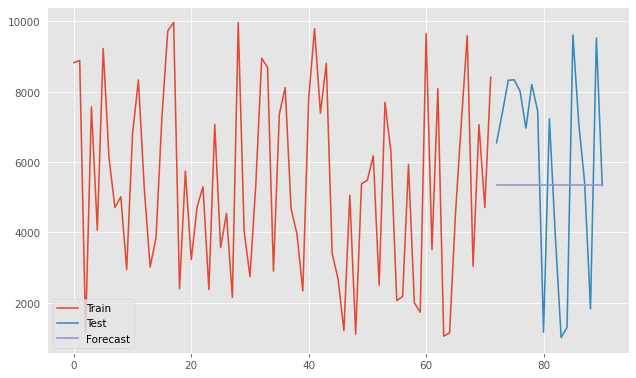

MAE: 2532.3830409356733
MSE: 8163957.987491881
RMSE: 2857.2640738111486


In [91]:
def auto_arima(dates, revenues):
    train, test = train_test_split(revenues, train_size=0.8)
    model = pmdarima.auto_arima(train, seasonal=True, m=30)
    forecast = model.predict(n_periods=len(test))
    plt.plot(numpy.arange(len(train)), train, label='Train')
    plt.plot(numpy.arange(len(train), len(train) + len(test)), test, label='Test')
    plt.plot(numpy.arange(len(train), len(train) + len(test)), forecast, label='Forecast')
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = mean_squared_error(test, forecast, squared=False)

    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)

auto_arima(dates, revenues)

C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


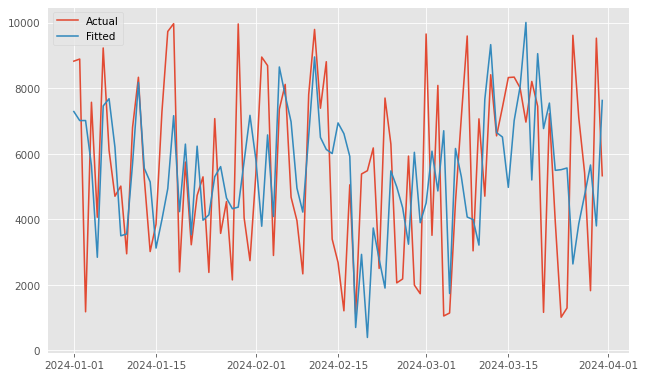

MAE: 2338.4647973644
MSE: 8362718.636161463
RMSE: 2891.8365507340595


In [101]:
def simple_expoential_smoothing(dates, revenues):
    model = sm.tsa.ExponentialSmoothing(revenues, trend='add', seasonal='add', seasonal_periods=30)
    model.fit(smoothing_level=0.2, smoothing_trend=0.2, smoothing_seasonal=0.2)
    
    # Predict values
    preds = model.predict(model.params, start=0, end=None)
    
    # Plot actual and predicted values
    plt.plot(dates, revenues, label='Actual')
    plt.plot(dates, preds, label='Fitted')
    plt.legend()
    plt.show()
    
    # Calculate metrics
    mae = mean_absolute_error(revenues, preds)
    mse = mean_squared_error(revenues, preds)
    rmse = mean_squared_error(revenues, preds, squared=False)
    
    # Print metrics
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    
simple_expoential_smoothing(dates, revenues)

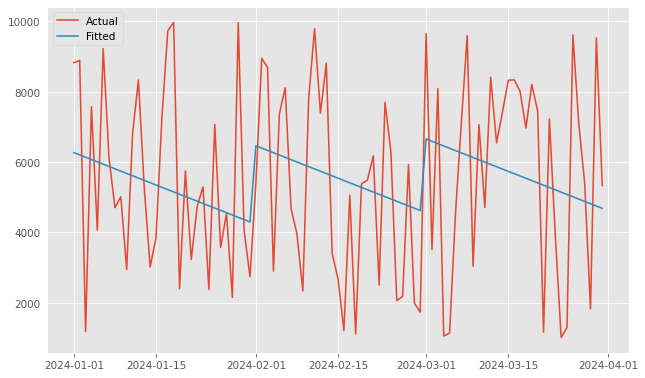

MAE: 2267.318133067588
MSE: 6933859.423162451
RMSE: 2633.2222510001793


In [95]:
def linear_regression(dates, revenues):
    from sklearn.linear_model import LinearRegression
    months = [d.month for d in dates]
    years = [d.year for d in dates]
    day = [d.day for d in dates]
    x = numpy.array([months, years, day]).T
    y = numpy.array(revenues)
    
    model = LinearRegression()
    model.fit(x, y=y)
    
    preds = model.predict(x)
    
    plt.plot(dates, revenues, label='Actual')
    plt.plot(dates, preds, label='Fitted')
    plt.legend()
    plt.show()
    
    mae = mean_absolute_error(revenues, preds)
    mse = mean_squared_error(revenues, preds)
    rmse = mean_squared_error(revenues, preds, squared=False)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    
linear_regression(dates, revenues)
    

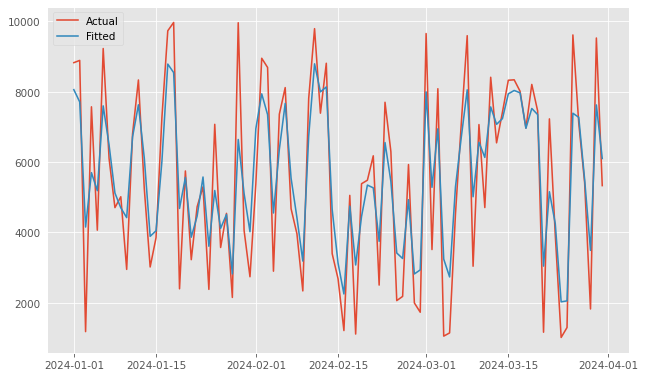

MAE: 1003.0657142857142
MSE: 1449272.6474
RMSE: 1203.8574032666825


In [96]:
def random_forest_regressor(dates, revenues):
    from sklearn.ensemble import RandomForestRegressor
    
    months = [d.month for d in dates]
    years = [d.year for d in dates]
    day = [d.day for d in dates]
    x = numpy.array([months, years, day]).T
    y = numpy.array(revenues)
    
    model = RandomForestRegressor()
    model.fit(x, y)
    
    preds = model.predict(x)
    
    plt.plot(dates, revenues, label='Actual')
    plt.plot(dates, preds, label='Fitted')
    plt.legend()
    plt.show()
    
    mae = mean_absolute_error(revenues, preds)
    mse = mean_squared_error(revenues, preds)
    rmse = mean_squared_error(revenues, preds, squared=False)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    
random_forest_regressor(dates, revenues)
    

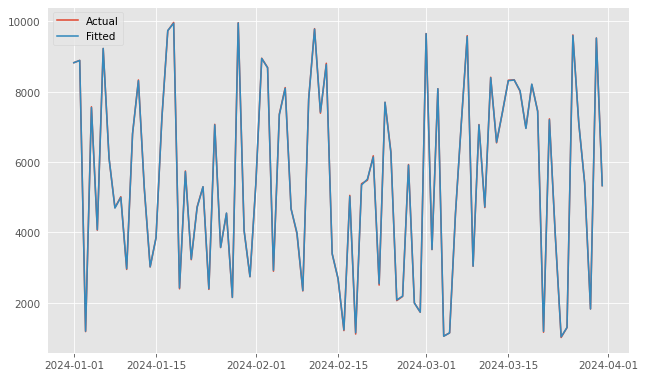

MAE: 13.027748862465659
MSE: 283.7544244128269
RMSE: 16.845011855526458


In [98]:
def xg_boost(dates, revenues):
    import xgboost as xgb
        
    months = [d.month for d in dates]
    years = [d.year for d in dates]
    day = [d.day for d in dates]
    x = numpy.array([months, years, day]).T
    y = numpy.array(revenues)
    
    model = xgb.XGBRegressor()
    model.fit(x, y)
    
    preds = model.predict(x)
    
    plt.plot(dates, revenues, label='Actual')
    plt.plot(dates, preds, label='Fitted')
    plt.legend()
    plt.show()
    
    mae = mean_absolute_error(revenues, preds)
    mse = mean_squared_error(revenues, preds)
    rmse = mean_squared_error(revenues, preds, squared=False)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)

xg_boost(dates, revenues)